In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
plt.rc('font',family='Microsoft YaHei')
data = pd.read_excel('data/待复购的用户列表.xlsx')

In [2]:
# 将字符串填充为 '无'，数值类型填充为 0
data['是否新下单'] = data['新下单金额'].notna().astype(int)
send_time = pd.to_datetime('2023-05-30 00:00:00')
data['注册时间'] = (send_time - data['注册日期']).dt.days
data['最后一次下单后累计时间'] =  (send_time - data['最后一次奶粉订单下单日期']).dt.days
data['预计复购累计时间'] = (send_time - data['预计应复购日期']).dt.days

data.fillna({
    '最后一次购买奶粉系列': '无',
    '最后一次购买奶粉段位': '无',
    '所在群': '无',
    '好友小助手': '无',
    '新下单数量': 0,
    '新下单金额': 0,
    '新下单商品数': 0,
    '新回访天数': 0,
    '新回访次数': 0,
    '新回访天均次数': 0,
    '新回访婴儿奶粉次数': 0,
    '新回访添加购物车数': 0
}, inplace=True)
data

,编号,注册日期,奶粉订单总数,购买奶粉总罐数,最后一次奶粉订单下单日期,最后一次奶粉订单购买罐数,最后一次奶粉预估食用天数,预计应复购日期,最后一次购买奶粉品牌,最后一次购买奶粉系列,...,新回访天数,新回访次数,新回访天均次数,新回访婴儿奶粉次数,新回访添加购物车数,赠送松多多免费券,是否新下单,注册时间,最后一次下单后累计时间,预计复购累计时间
0,10330960,2022-04-09 21:56:32.437,5,15,2022-12-28 11:35:30.267,2,14,2023-01-16 17:24:40.350,德国 爱他美,德国爱他美蓝罐,...,0.0,0.0,0.0,0.0,0.0,NaN,0,415,152,133
1,10331020,2022-04-10 08:58:54.003,1,2,2022-04-11 16:51:01.920,2,20,2022-05-06 18:01:30.013,德国 爱他美,德国爱他美白金,...,0.0,0.0,0.0,0.0,0.0,NaN,0,414,413,388
2,10331040,2022-04-10 09:12:29.683,1,6,2022-04-10 09:22:49.290,6,60,2022-06-14 13:01:39.727,澳洲 贝拉米,澳洲贝拉米有机,...,0.0,0.0,0.0,0.0,0.0,NaN,0,414,414,349
3,10331120,2022-04-10 19:58:48.877,5,13,2022-09-09 08:25:36.280,4,40,2022-10-26 16:13:11.207,荷兰 佳贝艾特,荷兰佳贝艾特羊奶,...,0.0,0.0,0.0,0.0,0.0,NaN,0,414,262,215
4,10331440,2022-04-11 18:28:45.720,5,30,2022-10-16 00:00:06.190,6,42,2022-12-02 11:17:37.057,德国 爱他美,德国爱他美白金,...,0.0,0.0,0.0,0.0,0.0,NaN,0,413,225,178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77228,17415700,2023-05-13 15:14:13.243,1,1,2023-05-13 15:25:13.627,1,6,2023-05-25 11:55:40.297,德国 爱他美,德国爱他美白金,...,1.0,5.0,5.0,2.0,0.0,NaN,0,16,16,4
77229,17416800,2023-05-13 16:44:48.640,1,1,2023-05-13 16:57:12.313,1,6,2023-05-25 11:59:52.170,德国 爱他美,德国爱他美白金,...,1.0,1.0,1.0,0.0,0.0,NaN,0,16,16,4
77230,17418760,2023-05-13 19:27:21.083,1,1,2023-05-13 19:50:49.137,1,6,2023-05-25 11:34:21.067,德国 爱他美,德国爱他美白金,...,0.0,0.0,0.0,0.0,0.0,NaN,0,16,16,4
77231,17419200,2023-05-13 20:16:54.973,1,1,2023-05-13 20:33:11.237,1,6,2023-05-25 11:56:09.880,德国 爱他美,德国爱他美白金,...,0.0,0.0,0.0,0.0,0.0,NaN,0,16,16,4


In [3]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]



In [4]:
data_Y = data[data['新下单金额'] != 0]
numeric_df = data_Y.select_dtypes(include=['number'])
numeric_df.corr()['新下单金额'].sort_values(ascending=False)

新下单金额           1.000000
新下单商品数          0.926633
新下单数量           0.530418
最后一次奶粉订单购买罐数    0.224738
最后一次奶粉预估食用天数    0.182556
新回访婴儿奶粉次数       0.138237
购买奶粉总罐数         0.131218
新回访添加购物车数       0.081485
新回访次数           0.061957
新回访天数           0.057917
新回访天均次数         0.057051
关注公众号           0.016158
编号              0.014837
奶粉订单总数         -0.004122
最后一次下单后累计时间    -0.004957
注册时间           -0.018618
预计复购累计时间       -0.037413
赠送松多多免费券             NaN
是否新下单                NaN
Name: 新下单金额, dtype: float64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77233 entries, 0 to 77232
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   编号            77233 non-null  int64         
 1   注册日期          77233 non-null  datetime64[ns]
 2   奶粉订单总数        77233 non-null  int64         
 3   购买奶粉总罐数       77233 non-null  int64         
 4   最后一次奶粉订单下单日期  77233 non-null  datetime64[ns]
 5   最后一次奶粉订单购买罐数  77233 non-null  int64         
 6   最后一次奶粉预估食用天数  77233 non-null  int64         
 7   预计应复购日期       77233 non-null  datetime64[ns]
 8   最后一次购买奶粉品牌    77233 non-null  object        
 9   最后一次购买奶粉系列    77233 non-null  object        
 10  最后一次购买奶粉段位    77233 non-null  object        
 11  关注公众号         77233 non-null  int64         
 12  所在群           77233 non-null  object        
 13  好友小助手         77233 non-null  object        
 14  新下单数量         77233 non-null  float64       
 15  新下单金额         77233 non-null  float6

In [6]:
g1 = data_Y[data_Y['最后一次购买奶粉品牌'] == '德国 爱他美']['新下单金额']
g2 = data_Y[data_Y['最后一次购买奶粉品牌'] == '澳洲 爱他美']['新下单金额']

ttest_ind(g1, g2)

TtestResult(statistic=0.31508992331032354, pvalue=0.7527146964339739, df=3084.0)

In [7]:
data[data['新回访添加购物车数'] !=0]

,编号,注册日期,奶粉订单总数,购买奶粉总罐数,最后一次奶粉订单下单日期,最后一次奶粉订单购买罐数,最后一次奶粉预估食用天数,预计应复购日期,最后一次购买奶粉品牌,最后一次购买奶粉系列,...,新回访天数,新回访次数,新回访天均次数,新回访婴儿奶粉次数,新回访添加购物车数,赠送松多多免费券,是否新下单,注册时间,最后一次下单后累计时间,预计复购累计时间
82,10336460,2022-04-16 13:20:26.563,2,8,2023-01-24 10:40:52.330,6,42,2023-03-12 13:50:03.273,德国 爱他美,德国爱他美白金,...,1.0,11.0,11.0,9.0,1.0,NaN,0,408,125,78
83,10336500,2022-04-16 13:42:00.533,4,8,2022-07-16 22:41:30.763,2,14,2022-08-05 10:11:04.437,德国 爱他美,德国爱他美白金,...,2.0,41.0,20.5,30.0,3.0,NaN,1,408,317,297
130,10338580,2022-04-17 13:29:19.530,2,12,2022-07-22 15:09:23.390,6,42,2022-09-08 10:00:43.350,德国 爱他美,德国爱他美白金,...,2.0,43.0,21.5,6.0,4.0,NaN,0,407,311,263
131,10338600,2022-04-17 13:33:50.367,3,8,2022-08-02 18:43:21.807,2,14,2022-08-22 10:11:16.487,德国 爱他美,德国爱他美白金,...,1.0,14.0,14.0,5.0,1.0,NaN,1,407,300,280
150,10339500,2022-04-17 14:44:50.457,10,38,2023-03-31 16:23:16.773,6,42,2023-05-18 10:55:45.183,德国 爱他美,德国爱他美白金,...,1.0,4.0,4.0,2.0,1.0,NaN,0,407,59,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77107,17133700,2023-05-09 15:39:06.870,1,1,2023-05-10 09:50:30.013,1,8,2023-05-23 14:52:54.597,香港 爱他美,香港爱他美白金,...,1.0,16.0,16.0,6.0,1.0,NaN,0,20,19,6
77118,17196340,2023-05-09 17:28:54.927,2,5,2023-05-09 17:34:06.263,1,6,2023-05-21 13:34:04.680,德国 爱他美,德国爱他美白金,...,1.0,5.0,5.0,3.0,1.0,NaN,1,20,20,8
77155,17359080,2023-05-10 16:17:34.353,1,1,2023-05-11 21:48:55.083,1,7,2023-05-24 10:31:57.670,德国 爱他美,德国爱他美白金,...,2.0,31.0,15.5,19.0,1.0,NaN,0,19,18,5
77190,17391560,2023-05-11 17:54:53.143,1,1,2023-05-12 07:19:07.320,1,6,2023-05-23 13:13:51.410,德国 爱他美,德国爱他美白金,...,1.0,9.0,9.0,5.0,1.0,NaN,0,18,17,6


In [8]:
select_cols = ['新回访次数', '新回访天均次数', '新回访婴儿奶粉次数', '新回访添加购物车数','最后一次购买奶粉品牌','最后一次购买奶粉系列','最后一次购买奶粉段位','最后一次奶粉订单购买罐数','最后一次奶粉预估食用天数']

In [9]:
data['最后一次购买奶粉品牌'].value_counts()

最后一次购买奶粉品牌
德国 爱他美       55844
澳洲 爱他美       10597
荷兰 牛栏         2379
澳洲 A2         1871
德国 雀巢         1659
英国 爱他美        1102
爱他美            676
澳洲 雀巢          446
荷兰 美素          416
美素佳儿           402
澳洲 贝拉米         248
英国 牛栏          205
德国 喜宝          183
澳洲 雅培小安素       120
荷兰 佳贝艾特         99
澳洲 贝儿           96
澳洲 可瑞康          90
港版 雀巢           80
荷兰 雀巢           77
澳洲 纽康特          75
波兰 牛栏           71
澳洲 合生元          49
丹麦 阿拉           49
伊利              43
香港 牛栏           42
香港 爱他美          42
a2至初            37
瑞士 雀巢           29
荷兰 美赞臣          23
法国 佳丽雅          21
荷兰 诺优能          17
澳洲 惠氏           16
爱尔兰 惠氏          14
英国 雀巢           10
美国 雅培            9
港版 佳贝艾特          9
澳洲 雅培            7
法国 合生元           7
港版 美赞臣           7
贝因美              6
澳洲 颖睿            6
港版 雅培            5
荷兰 喜宝            5
飞鹤               5
君乐宝              5
法国 伴宝乐           4
波兰 雀巢            3
波兰 纽康特           3
澳洲 拜耳            3
英国 纳尼凯尔          3
澳洲 诺崔特           3
澳大利亚 纳诺可儿        3
新

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
clu1 = data_Y[['最后一次购买奶粉品牌','新下单金额']]
clu2 = data_Y[['最后一次购买奶粉系列','新下单金额']]
clu3 = data_Y[['最后一次购买奶粉段位','新下单金额']]
feature_df = clu3.groupby('最后一次购买奶粉段位')['新下单金额'].agg(['mean', 'median']).reset_index().dropna()
feature_df

,最后一次购买奶粉段位,mean,median
0,1+段,716.871495,760.00
1,1段,925.134570,870.00
2,2+段,722.129167,462.75
3,2段,880.499245,800.00
4,3段,717.421416,480.00
5,4段,600.748276,390.00
6,5段,684.000000,684.00
7,AllerPro深水解,414.500000,420.00
8,De-Lact无乳糖,432.000000,432.00
9,GOLD（金装版）,506.000000,506.00


In [11]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feature_df[['mean', 'median']])
k = 5
kmeans = KMeans(n_clusters=k, random_state=0)
feature_df['cluster'] =kmeans.fit_predict(features_scaled)
feature_df


,最后一次购买奶粉段位,mean,median,cluster
0,1+段,716.871495,760.00,0
1,1段,925.134570,870.00,0
2,2+段,722.129167,462.75,3
3,2段,880.499245,800.00,0
4,3段,717.421416,480.00,3
5,4段,600.748276,390.00,3
6,5段,684.000000,684.00,3
7,AllerPro深水解,414.500000,420.00,1
8,De-Lact无乳糖,432.000000,432.00,1
9,GOLD（金装版）,506.000000,506.00,3


In [15]:
encoding_dict1  = {
    '1+段': 0, '1段': 0, '2段': 0, 'Pre段': 0,
    '糖尿病专用奶粉': 1, 'PRE段': 1, 'De-Lact无乳糖': 1, 'AllerPro深水解': 1,
    '香草': 2,
    'GOLD（金装版）': 3, '4段': 3, '3段': 3, 'pre段': 3, '无': 3, '深度水解': 3, '2+段': 3, '5段': 3,
    '蔼儿舒': 4, '原味': 4, '恩敏舒1+': 4, '肽敏舒': 4, 'LCP（普通版）': 4,
    '其他': 5
}

encoding_dict2 = {"a2至初": 0, "荷兰 美素": 0, "荷兰 佳贝艾特": 0, "德国 喜宝": 0, "美素佳儿": 0,
                  "澳洲 雅培": 0, "澳洲 雀巢": 0, "澳洲 贝儿": 0, "澳洲 纽康特": 0, "澳洲 雅培小安素": 1,
                  "爱他美": 2, "香港 爱他美": 2, "澳洲 贝拉米": 2, "澳洲 A2": 2, "德国 爱他美": 2,
                  "澳洲 爱他美": 2, "澳洲 可瑞康": 3, "港版 美赞臣": 3, "波兰 牛栏": 3, "澳洲 颖睿": 3,
                  "英国 牛栏": 3, "伊利": 3, "丹麦 阿拉": 3, "荷兰 雀巢": 3, "香港 牛栏": 3,
                  "港版 雀巢": 4, "德国 雀巢": 4, "英国 爱他美": 4, "荷兰 牛栏": 4, "其他": 5
                    }
encoding_dict3 = {
    'A2儿童奶粉': 0, '颖睿亲和乳元羊奶': 0, '澳洲雅培成人奶粉': 0, '澳洲可瑞康羊奶': 0,
    '英国牛栏': 0, '港版美赞臣A+': 0, '港版美素佳儿金装': 0, '澳洲雀巢水解奶粉': 0,
    '港版牛栏': 0, '波兰牛栏水解奶粉': 0, '澳洲雀巢儿童奶粉': 0, '伊利金领冠塞纳牧': 0,
    '荷兰美素白金': 0, '荷兰美素纸盒': 0, '荷兰雀巢水解奶粉': 0, '雀巢能恩安儿宁': 0,
    '雀巢超启能恩': 0, '荷兰牛栏白金': 0, '丹麦阿拉白金': 0, '澳洲贝拉米有机': 1,
    '德国爱他美白金': 1, '爱他美奇迹白罐': 1, '爱他美卓萃白金': 1, '澳洲爱他美白金': 1,
    '澳洲雀巢能恩': 2, '荷兰牛栏易乐罐': 2, '英国爱他美白金': 2, '荷兰皇家美素佳儿': 2,
    '爱他美国行蓝罐': 2, '荷兰佳贝艾特羊奶': 2, '澳洲贝儿贝臻牛奶': 2, '澳洲纽康特特配奶': 2,
    '澳洲爱他美金装': 2, '澳洲爱他美水解奶': 2, 'A2至初白金奶粉': 2, '澳洲可瑞康绵羊奶': 2,
    '德国喜宝有机': 2, '德国喜宝益生菌': 2, '澳洲贝拉米白金': 2, '德国雀巢BEBA': 2,
    '德国爱他美蓝罐': 2, '佳贝艾特悦白羊奶': 3, '雀巢特别能恩': 3, '荷兰美素白金+': 3,
    '荷兰牛栏水解奶粉': 3, '港版皇家美素佳儿': 3, '港版雀巢能恩全护': 3, '澳洲A2白金': 3,
    '无': 3, '香港爱他美白金': 3, '小安素儿童奶粉': 4, '爱他美奇迹蓝罐': 4, '澳洲爱他美光耀': 4,
    '其他': 5
}





In [17]:
data['encoded'] = data['最后一次购买奶粉系列'].apply(lambda x: encoding_dict3.get(x, 5))
df_encoded = pd.get_dummies(data['encoded'], prefix='最后一次购买奶粉系列').astype(int)
data = pd.concat([data, df_encoded], axis=1)


In [30]:
feature_1 = ['新回访次数', '新回访天均次数', '新回访婴儿奶粉次数', '新回访添加购物车数','是否新下单']
feature_0 = ['新回访次数', '新回访天均次数', '新回访婴儿奶粉次数', '新回访添加购物车数']
data_C = pd.concat([data[data['新回访婴儿奶粉次数'] != 0].sample(n=1500, random_state=42),data[data['新回访婴儿奶粉次数'] == 0].sample(n=1500, random_state=42)],ignore_index=True)
data_C = data_C[feature_1]
data_C
                

,新回访次数,新回访天均次数,新回访婴儿奶粉次数,新回访添加购物车数,是否新下单
0,7.0,7.0,6.0,0.0,0
1,21.0,10.5,12.0,0.0,1
2,4.0,4.0,2.0,1.0,0
3,7.0,7.0,2.0,0.0,0
4,3.0,3.0,2.0,0.0,0
...,...,...,...,...,...
2995,2.0,2.0,0.0,0.0,0
2996,0.0,0.0,0.0,0.0,0
2997,0.0,0.0,0.0,0.0,0
2998,0.0,0.0,0.0,0.0,0


In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


X_train = data_C[feature_0]
y_train = data_C['是否新下单']
X_test = data[feature_0]
y_test = data['是否新下单']

clf = DecisionTreeClassifier(random_state=42)


clf.fit(X_train, y_train)

# 5. 做出预测
y_pred = clf.predict(X_test)

# 6. 评估模型（可以使用准确率作为评估指标）
accuracy = accuracy_score(y_test, y_pred)
print(f"模型准确率: {accuracy:.2f}")


模型准确率: 0.95


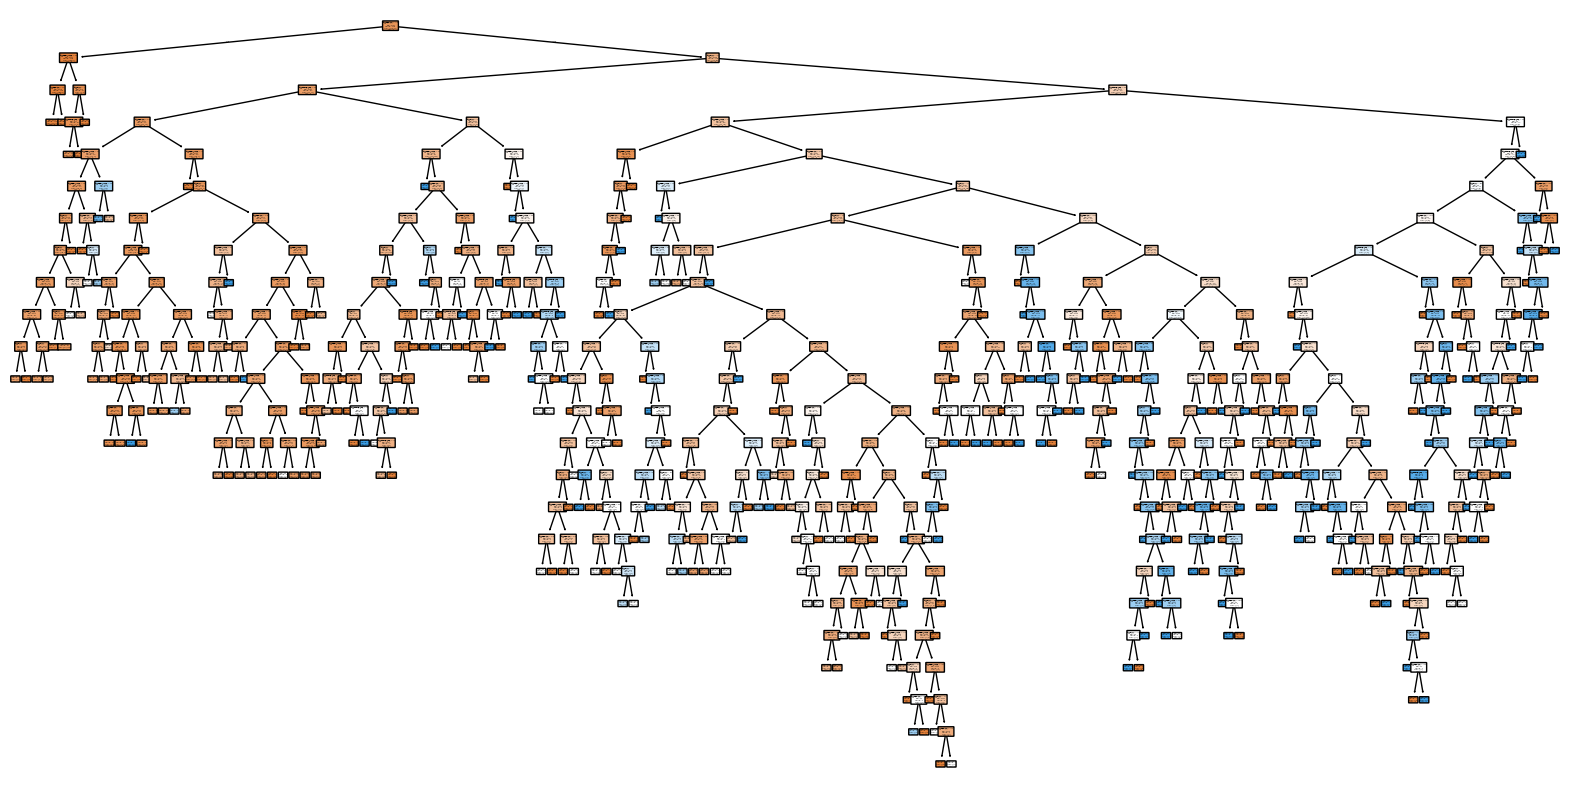

In [42]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.figure(figsize=(20, 10))  # 设置图像大小
plot_tree(clf, feature_names=feature_0, class_names=['0','1'], filled=True, rounded=True)
plt.show()

In [45]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[72611,  1096],
       [ 2562,   964]], dtype=int64)

In [49]:
data_Y = data[data['新下单金额'] != 0]
data_U = remove_outliers_iqr(data_Y, '新下单金额')
data_U

,编号,注册日期,奶粉订单总数,购买奶粉总罐数,最后一次奶粉订单下单日期,最后一次奶粉订单购买罐数,最后一次奶粉预估食用天数,预计应复购日期,最后一次购买奶粉品牌,最后一次购买奶粉系列,...,最后一次购买奶粉品牌_2,最后一次购买奶粉品牌_3,最后一次购买奶粉品牌_4,最后一次购买奶粉品牌_5,最后一次购买奶粉系列_0,最后一次购买奶粉系列_1,最后一次购买奶粉系列_2,最后一次购买奶粉系列_3,最后一次购买奶粉系列_4,最后一次购买奶粉系列_5
37,10334080,2022-04-15 10:30:55.390,3,6,2022-09-28 15:45:21.710,2,14,2022-10-18 13:02:58.363,德国 爱他美,德国爱他美白金,...,1,0,0,0,0,1,0,0,0,0
83,10336500,2022-04-16 13:42:00.533,4,8,2022-07-16 22:41:30.763,2,14,2022-08-05 10:11:04.437,德国 爱他美,德国爱他美白金,...,1,0,0,0,0,1,0,0,0,0
131,10338600,2022-04-17 13:33:50.367,3,8,2022-08-02 18:43:21.807,2,14,2022-08-22 10:11:16.487,德国 爱他美,德国爱他美白金,...,1,0,0,0,0,1,0,0,0,0
288,10344340,2022-04-17 20:48:58.013,7,16,2022-06-17 16:22:10.857,2,14,2022-07-07 09:47:12.950,德国 爱他美,德国爱他美白金,...,1,0,0,0,0,1,0,0,0,0
303,10344840,2022-04-17 22:49:52.193,17,42,2022-10-16 17:48:13.780,4,40,2022-12-01 10:28:47.273,澳洲 A2,澳洲A2白金,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77182,17386360,2023-05-11 13:06:50.333,1,1,2023-05-11 13:10:43.167,1,6,2023-05-23 09:16:55.893,爱他美,爱他美奇迹蓝罐,...,1,0,0,0,0,0,0,0,1,0
77183,17388660,2023-05-11 15:15:57.660,2,3,2023-05-11 15:41:10.107,1,6,2023-05-23 10:01:19.460,德国 爱他美,德国爱他美白金,...,1,0,0,0,0,1,0,0,0,0
77213,17402600,2023-05-12 15:08:26.237,1,1,2023-05-12 15:48:28.450,1,6,2023-05-24 14:02:01.570,德国 爱他美,德国爱他美白金,...,1,0,0,0,0,1,0,0,0,0
77215,17404880,2023-05-12 16:56:20.857,1,1,2023-05-13 21:53:46.560,1,6,2023-05-25 11:13:39.017,德国 爱他美,德国爱他美白金,...,1,0,0,0,0,1,0,0,0,0


In [55]:
feature_R = ['最后一次奶粉订单购买罐数','最后一次奶粉预估食用天数','最后一次购买奶粉段位_0', '最后一次购买奶粉段位_1',
             '最后一次购买奶粉段位_2', '最后一次购买奶粉段位_3', '最后一次购买奶粉段位_4', '最后一次购买奶粉段位_5',
             '最后一次购买奶粉品牌_0', '最后一次购买奶粉品牌_1', '最后一次购买奶粉品牌_2', '最后一次购买奶粉品牌_3',
             '最后一次购买奶粉品牌_4', '最后一次购买奶粉品牌_5', '最后一次购买奶粉系列_0', '最后一次购买奶粉系列_1',
             '最后一次购买奶粉系列_2', '最后一次购买奶粉系列_3', '最后一次购买奶粉系列_4', '最后一次购买奶粉系列_5','新下单金额']

data_R = data_U[feature_R].sample(n=1500, random_state=42)

X_train_R = data_R.drop(columns='新下单金额')
y_train_R = data_R['新下单金额']
X_test_R = data[feature_R].drop(columns='新下单金额')
y_test_R = data['新下单金额']

In [56]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train_R, y_train_R)
y_pred_R = regressor.predict(X_test_R)
mse = mean_squared_error(y_test_R, y_pred_R)
r2 = r2_score(y_test_R, y_pred_R)
mse,r2

(674450.8846694393, -11.348274828800038)

In [74]:
import xgboost as xgb
model = xgb.XGBRegressor(n_estimators=100, random_state=42)

model.fit(X_train_R, y_train_R)

y_pred_R = model.predict(X_test_R)
mse = mean_squared_error(y_test_R, y_pred_R)
r2 = r2_score(y_test_R, y_pred_R)
mse,r2

(666700.2148395488, -11.206370646683522)

In [83]:
s= pd.Series(y_pred)
temp = data.assign(W=s)

In [90]:
temp = temp[(temp['是否新下单'] == 0) & (temp['W'] == 1)][['编号','W']]

In [91]:
df_merged = pd.merge(data, temp[['编号', 'W']], on='编号', how='left')
df_merged

,编号,注册日期,奶粉订单总数,购买奶粉总罐数,最后一次奶粉订单下单日期,最后一次奶粉订单购买罐数,最后一次奶粉预估食用天数,预计应复购日期,最后一次购买奶粉品牌,最后一次购买奶粉系列,...,最后一次购买奶粉品牌_3,最后一次购买奶粉品牌_4,最后一次购买奶粉品牌_5,最后一次购买奶粉系列_0,最后一次购买奶粉系列_1,最后一次购买奶粉系列_2,最后一次购买奶粉系列_3,最后一次购买奶粉系列_4,最后一次购买奶粉系列_5,W
0,10330960,2022-04-09 21:56:32.437,5,15,2022-12-28 11:35:30.267,2,14,2023-01-16 17:24:40.350,德国 爱他美,德国爱他美蓝罐,...,0,0,0,0,0,1,0,0,0,NaN
1,10331020,2022-04-10 08:58:54.003,1,2,2022-04-11 16:51:01.920,2,20,2022-05-06 18:01:30.013,德国 爱他美,德国爱他美白金,...,0,0,0,0,1,0,0,0,0,NaN
2,10331040,2022-04-10 09:12:29.683,1,6,2022-04-10 09:22:49.290,6,60,2022-06-14 13:01:39.727,澳洲 贝拉米,澳洲贝拉米有机,...,0,0,0,0,1,0,0,0,0,NaN
3,10331120,2022-04-10 19:58:48.877,5,13,2022-09-09 08:25:36.280,4,40,2022-10-26 16:13:11.207,荷兰 佳贝艾特,荷兰佳贝艾特羊奶,...,0,0,0,0,0,1,0,0,0,NaN
4,10331440,2022-04-11 18:28:45.720,5,30,2022-10-16 00:00:06.190,6,42,2022-12-02 11:17:37.057,德国 爱他美,德国爱他美白金,...,0,0,0,0,1,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77228,17415700,2023-05-13 15:14:13.243,1,1,2023-05-13 15:25:13.627,1,6,2023-05-25 11:55:40.297,德国 爱他美,德国爱他美白金,...,0,0,0,0,1,0,0,0,0,NaN
77229,17416800,2023-05-13 16:44:48.640,1,1,2023-05-13 16:57:12.313,1,6,2023-05-25 11:59:52.170,德国 爱他美,德国爱他美白金,...,0,0,0,0,1,0,0,0,0,NaN
77230,17418760,2023-05-13 19:27:21.083,1,1,2023-05-13 19:50:49.137,1,6,2023-05-25 11:34:21.067,德国 爱他美,德国爱他美白金,...,0,0,0,0,1,0,0,0,0,NaN
77231,17419200,2023-05-13 20:16:54.973,1,1,2023-05-13 20:33:11.237,1,6,2023-05-25 11:56:09.880,德国 爱他美,德国爱他美白金,...,0,0,0,0,1,0,0,0,0,NaN


In [93]:
df_merged['W'] = df_merged['W'].replace(1, 'Y')
df_merged[['编号','W']]

,编号,W
0,10330960,NaN
1,10331020,NaN
2,10331040,NaN
3,10331120,NaN
4,10331440,NaN
...,...,...
77228,17415700,NaN
77229,17416800,NaN
77230,17418760,NaN
77231,17419200,NaN


In [94]:
df_merged.to_excel('data/temp.xlsx', index=False)